## ***Import Libraries***

In [1]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2
import nibabel as nib
import warnings
warnings.filterwarnings('ignore')

## ***Define Paths and Prepare for Data***

In [2]:
train_dir = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
val_dir = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData"

In [12]:
class BraTSDataset(Dataset):
    def __init__(self, patient_list, data_dir, is_train=True, transform=None, slice_range=(60, 100)):
        self.data_dir = data_dir
        self.is_train = is_train
        self.transform = transform
        self.modalities = ["flair", "t1", "t1ce", "t2"]
        self.patients = [p for p in patient_list if not p.endswith(".csv")]
        self.slice_range = slice_range  # Only load a range of slices to save memory
        
    def load_nifti(self, path):
        nifti_img = nib.load(path)
        return np.array(nifti_img.get_fdata(), dtype=np.float32)
    
    def __len__(self):
        return len(self.patients)
    
    def __getitem__(self, idx):
        patient_id = self.patients[idx]
        patient_path = os.path.join(self.data_dir, patient_id)
        
        # Load 4 MR modalities
        images = []
        for modality in self.modalities:
            img_path = os.path.join(patient_path, f"{patient_id}_{modality}.nii")
            img = self.load_nifti(img_path)
            
            # Only keep the central axial slices where tumor is most likely to be visible
            start_slice, end_slice = self.slice_range
            img = img[:, :, start_slice:end_slice]
            
            # Z-score normalization for better stability
            if np.std(img) > 0:
                img = (img - np.mean(img)) / np.std(img)
            else:
                img = np.zeros_like(img)
            
            images.append(img)
            
        # Stack images as channels
        images = np.stack(images, axis=0)  # (4, H, W, D_reduced)
        
        # To PyTorch Tensor
        images = torch.tensor(images, dtype=torch.float32)
        
        # If it is a train_set load segmentation mask too
        if self.is_train:
            # Try multiple possible segmentation file names
            seg_paths = [
                os.path.join(patient_path, f"{patient_id}_seg.nii"),
                os.path.join(patient_path, f"{patient_id}_Segm.nii"),
                os.path.join(patient_path, f"{patient_id}_Segmentation.nii")
            ]
            
            # Find the first existing segmentation file
            seg_path = next((path for path in seg_paths if os.path.exists(path)), None)
            
            if seg_path is None:
                raise FileNotFoundError(f"No segmentation file found for patient {patient_id}")
            
            mask = self.load_nifti(seg_path)
            
            # Get the same slice range
            mask = mask[:, :, self.slice_range[0]:self.slice_range[1]]
            
            # Convert to binary mask
            mask = (mask > 0).astype(np.float32)
            mask = torch.tensor(mask, dtype=torch.long)
        else:
            mask = None
                
        return (images, mask) if self.is_train else images

# Optimize memory by selecting a subset of patients for quick testing
def get_subset_patients(patient_list, ratio=0.3):
    """Get a subset of patients for memory-efficient training"""
    n_patients = max(2, int(len(patient_list) * ratio))
    return random.sample(patient_list, n_patients)

In [13]:
# Prepare datasets (with memory optimization)
all_train_patients = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
all_test_patients = sorted([d for d in os.listdir(val_dir) if os.path.isdir(os.path.join(val_dir, d))])

# For quick testing/debugging, use smaller subset
use_subset = True  # Set to False for full training
if use_subset:
    all_train_patients = get_subset_patients(all_train_patients, ratio=0.2)
    all_test_patients = get_subset_patients(all_test_patients, ratio=0.2)

print(f"Using {len(all_train_patients)} training patients and {len(all_test_patients)} test patients")

# Split training data into train and validation
train_patients, val_patients = train_test_split(all_train_patients, test_size=0.2, random_state=42)

# Create datasets with reduced slice range to save memory
train_dataset = BraTSDataset(train_patients, train_dir, slice_range=(60, 100))
val_dataset = BraTSDataset(val_patients, train_dir, slice_range=(60, 100))
test_dataset = BraTSDataset(all_test_patients, val_dir, is_train=False, slice_range=(60, 100))

# DataLoaders with small batch_size but more workers if available
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

# Check sample data dimensions
sample_img, sample_mask = next(iter(train_loader))
print(f"Train set image dimension: {sample_img.shape}")  # Should be smaller now
print(f"Train set segmentation dimension: {sample_mask.shape}")

sample_img, sample_mask = next(iter(val_loader))
print("Validation set image dimension:", sample_img.shape)
print("Validation set segmentation dimension:", sample_mask.shape)

sample_img = next(iter(test_loader))
print("Test set image dimension:", sample_img.shape)

Using 73 training patients and 25 test patients
Train set image dimension: torch.Size([1, 4, 240, 240, 40])
Train set segmentation dimension: torch.Size([1, 240, 240, 40])
Validation set image dimension: torch.Size([1, 4, 240, 240, 40])
Validation set segmentation dimension: torch.Size([1, 240, 240, 40])
Test set image dimension: torch.Size([1, 4, 240, 240, 40])


In [14]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    torch.cuda.empty_cache()  # Clear GPU cache before starting
    print(f"Using {num_gpus} GPUs for training." if num_gpus > 1 else 
          f"Using {torch.cuda.get_device_name(0)} for training.")
else:
    print("Using CPU for training.")

Using Tesla P100-PCIE-16GB for training.


## ***Building Model Architecture, Dice Loss and Setting Hyperparameters***

In [15]:
# Improved 3D UNet with residual connections and deeper architecture
class ImprovedUNet3D(nn.Module):
    def __init__(self, in_channels=4, out_channels=2, base_filters=16):
        super(ImprovedUNet3D, self).__init__()
        
        # Encoder path with residual blocks
        self.enc1 = self._make_layer(in_channels, base_filters)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        
        self.enc2 = self._make_layer(base_filters, base_filters*2)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        
        self.enc3 = self._make_layer(base_filters*2, base_filters*4)
        
        # Decoder path with skip connections
        self.upconv2 = nn.ConvTranspose3d(base_filters*4, base_filters*2, kernel_size=2, stride=2)
        self.dec2 = self._make_layer(base_filters*4, base_filters*2)
        
        self.upconv1 = nn.ConvTranspose3d(base_filters*2, base_filters, kernel_size=2, stride=2)
        self.dec1 = self._make_layer(base_filters*2, base_filters)
        
        # Output layer with dropout for regularization
        self.dropout = nn.Dropout3d(0.3)
        self.final_conv = nn.Conv3d(base_filters, out_channels, kernel_size=1)
        
        # Initialize weights for better convergence
        self._initialize_weights()
        
    def _make_layer(self, in_channels, out_channels):
        """Create a residual block"""
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm3d(out_channels),  # More stable than BatchNorm for small batches
            nn.LeakyReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm3d(out_channels),
            nn.LeakyReLU(inplace=True)
        )
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.InstanceNorm3d):
                if m.weight is not None:  # Eğer weight tanımlıysa
                    nn.init.constant_(m.weight, 1)
                if m.bias is not None:  # Eğer bias tanımlıysa
                    nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        # Encoder
        enc1_out = self.enc1(x)
        p1 = self.pool1(enc1_out)
        
        enc2_out = self.enc2(p1)
        p2 = self.pool2(enc2_out)
        
        # Bottom level
        enc3_out = self.enc3(p2)
        
        # Decoder with skip connections
        up2 = self.upconv2(enc3_out)
        # Ensure sizes match for skip connection
        diffY = enc2_out.size()[2] - up2.size()[2]
        diffX = enc2_out.size()[3] - up2.size()[3]
        diffZ = enc2_out.size()[4] - up2.size()[4]
        
        up2 = F.pad(up2, [
            diffZ // 2, diffZ - diffZ // 2,
            diffX // 2, diffX - diffX // 2,
            diffY // 2, diffY - diffY // 2
        ])
        concat2 = torch.cat([up2, enc2_out], dim=1)
        dec2_out = self.dec2(concat2)
        
        up1 = self.upconv1(dec2_out)
        # Ensure sizes match for skip connection
        diffY = enc1_out.size()[2] - up1.size()[2]
        diffX = enc1_out.size()[3] - up1.size()[3]
        diffZ = enc1_out.size()[4] - up1.size()[4]
        
        up1 = F.pad(up1, [
            diffZ // 2, diffZ - diffZ // 2,
            diffX // 2, diffX - diffX // 2,
            diffY // 2, diffY - diffY // 2
        ])
        concat1 = torch.cat([up1, enc1_out], dim=1)
        dec1_out = self.dec1(concat1)
        
        # Apply dropout for regularization
        x = self.dropout(dec1_out)
        
        # Final classification layer
        out = self.final_conv(x)
        
        return out

In [16]:
# Dice Loss implementation for better segmentation results
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, y_pred, y_true):
        # Flatten tensors
        y_pred = y_pred.contiguous().view(-1)
        y_true = y_true.contiguous().view(-1)
        
        # Compute Dice coefficient
        intersection = (y_pred * y_true).sum()
        dice = (2. * intersection + self.smooth) / (y_pred.sum() + y_true.sum() + self.smooth)
        
        return 1 - dice

# Combination of CrossEntropy and Dice loss for better performance
class CombinedLoss(nn.Module):
    def __init__(self, weight_dice=0.7, weight_ce=0.3):
        super(CombinedLoss, self).__init__()
        self.weight_dice = weight_dice
        self.weight_ce = weight_ce
        self.dice_loss = DiceLoss()
        self.ce_loss = nn.CrossEntropyLoss()
        
    def forward(self, inputs, targets):
        # Cross entropy component
        ce_loss = self.ce_loss(inputs, targets)
        
        # Get predicted class probabilities for dice loss
        probs = F.softmax(inputs, dim=1)
        
        # Get binary predictions for the positive class (index 1)
        predicted_class = probs[:, 1]
        target_one_hot = torch.zeros_like(probs)
        target_one_hot.scatter_(1, targets.unsqueeze(1), 1)
        target_class = target_one_hot[:, 1]
        
        # Compute dice loss on the positive (tumor) class
        dice_loss = self.dice_loss(predicted_class, target_class)
        
        # Combine losses
        return self.weight_ce * ce_loss + self.weight_dice * dice_loss

In [17]:
# Initialize model with improved architecture
model = ImprovedUNet3D(in_channels=4, out_channels=2, base_filters=16)
model = model.to(device)

# Use mixed precision for memory efficiency
use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

# Use combined loss for better segmentation results
criterion = CombinedLoss(weight_dice=0.7, weight_ce=0.3)

# Cosine annealing learning rate for better convergence
optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)

# Updated Dice coefficient for evaluation
def dice_coefficient(y_pred, y_true, smooth=1e-6):
    # Flatten tensors
    y_pred = y_pred.contiguous().view(-1)
    y_true = y_true.contiguous().view(-1)
    
    # Calculate intersection and dice coefficient
    intersection = (y_pred * y_true).sum()
    dice = (2. * intersection + smooth) / (y_pred.sum() + y_true.sum() + smooth)
    
    return dice.item()

## ***Train-Validation Functions***

In [18]:
# Function to train for one epoch with memory optimization
def train_one_epoch(model, dataloader, optimizer, criterion, device, scaler=None):
    model.train()
    epoch_loss = 0.0
    dice_score = 0.0
    batch_count = 0
    
    for i, (inputs, targets) in enumerate(dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass with mixed precision
        if use_amp:
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            
            # Backward pass with gradient scaling
            scaler.scale(loss).backward()
            
            # Gradient clipping to prevent exploding gradients
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            scaler.step(optimizer)
            scaler.update()
        else:
            # Standard forward and backward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
        
        # Update metrics
        epoch_loss += loss.item()
        
        # Get predictions
        if outputs.shape[1] > 1:  # Multi-class case
            _, preds = torch.max(outputs, 1)
        else:  # Binary case
            preds = (torch.sigmoid(outputs) > 0.5).float()
        
        # Calculate Dice coefficient
        dice = dice_coefficient(preds, targets)
        dice_score += dice
        batch_count += 1
        
        # Print progress
        if (i+1) % 5 == 0:
            print(f"Batch {i+1}/{len(dataloader)}, Loss: {loss.item():.4f}, Dice: {dice:.4f}")
            
        # Free up memory
        del inputs, targets, outputs, preds
        torch.cuda.empty_cache()
    
    # Calculate average metrics
    avg_loss = epoch_loss / batch_count
    avg_dice = dice_score / batch_count
    
    return avg_loss, avg_dice

# Function to validate for one epoch with memory optimization
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0.0
    dice_score = 0.0
    batch_count = 0
    
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dataloader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Forward pass
            if use_amp:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            
            # Update statistics
            epoch_loss += loss.item()
            
            # Get predictions
            if outputs.shape[1] > 1:  # Multi-class case
                _, preds = torch.max(outputs, 1)
            else:  # Binary case
                preds = (torch.sigmoid(outputs) > 0.5).float()
            
            # Calculate Dice coefficient
            dice = dice_coefficient(preds, targets)
            dice_score += dice
            batch_count += 1
            
            # Free up memory
            del inputs, targets, outputs, preds
            torch.cuda.empty_cache()
    
    # Calculate average metrics
    avg_loss = epoch_loss / batch_count
    avg_dice = dice_score / batch_count
    
    return avg_loss, avg_dice

# Early stopping implementation
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

## ***Training***

Epoch [1/100]
Batch 5/58, Loss: 0.8041, Dice: 0.1254
Batch 10/58, Loss: 0.4629, Dice: 0.5405
Batch 15/58, Loss: 0.8405, Dice: 0.1964
Batch 20/58, Loss: 0.5725, Dice: 0.5166
Batch 25/58, Loss: 0.9595, Dice: 0.0846
Batch 30/58, Loss: 0.8648, Dice: 0.1066
Batch 35/58, Loss: 0.7861, Dice: 0.2781
Batch 40/58, Loss: 0.7274, Dice: 0.3390
Batch 45/58, Loss: 0.7554, Dice: 0.1538
Batch 50/58, Loss: 0.7375, Dice: 0.2258
Batch 55/58, Loss: 0.2948, Dice: 0.7448
Epoch [1/100], Train Loss: 0.7180, Train Dice: 0.2836
Validation Loss: 0.5340, Validation Dice: 0.4940, LR: 0.000200
Best model saved with Dice score: 0.4940!
Epoch [2/100]
Batch 5/58, Loss: 0.7901, Dice: 0.2651
Batch 10/58, Loss: 0.6143, Dice: 0.7145
Batch 15/58, Loss: 0.7826, Dice: 0.1550
Batch 20/58, Loss: 0.4585, Dice: 0.5138
Batch 25/58, Loss: 0.2309, Dice: 0.7697
Batch 30/58, Loss: 0.8566, Dice: 0.0250
Batch 35/58, Loss: 0.6898, Dice: 0.2218
Batch 40/58, Loss: 0.1195, Dice: 0.9020
Batch 45/58, Loss: 0.4058, Dice: 0.5926
Batch 50/58, Lo

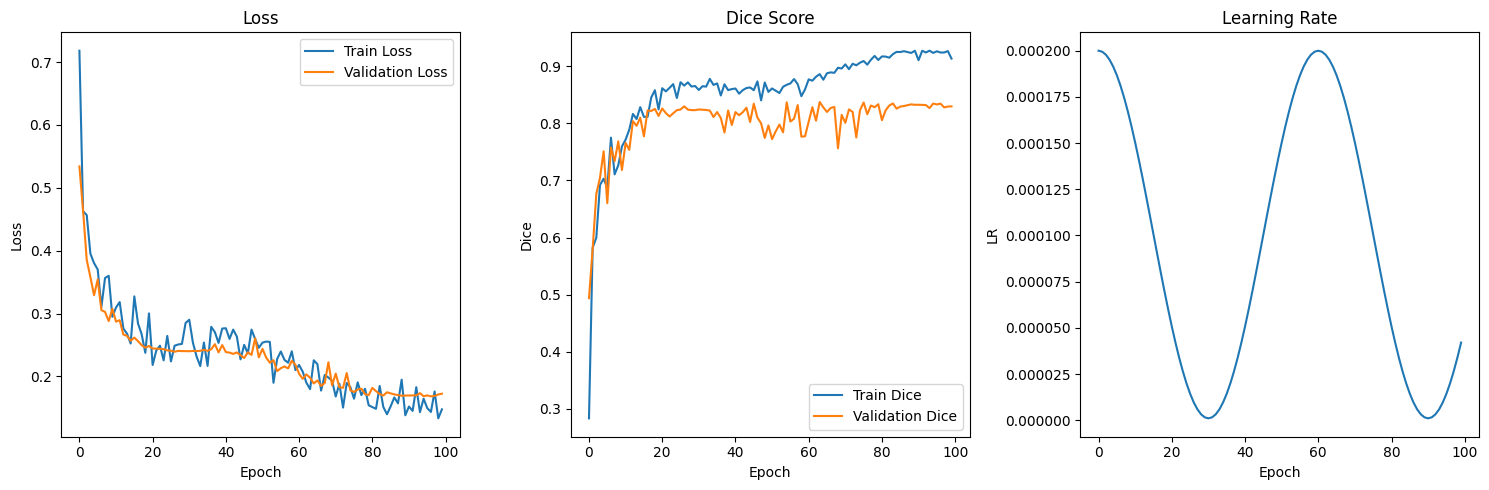

Training completed! Best validation Dice score: 0.8372


In [19]:
# Training loop with early stopping
num_epochs = 100  # Increased epochs with early stopping
best_val_dice = 0.0
early_stopping = EarlyStopping(patience=10)

# Lists to store metrics
train_losses = []
val_losses = []
train_dice_scores = []
val_dice_scores = []
learning_rates = []

try:
    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        
        # Train
        train_loss, train_dice = train_one_epoch(model, train_loader, optimizer, criterion, device, scaler)
        train_losses.append(train_loss)
        train_dice_scores.append(train_dice)
        
        # Update learning rate
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        scheduler.step()
        
        # Free memory before validation
        torch.cuda.empty_cache()
        
        # Validate
        val_loss, val_dice = validate_one_epoch(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_dice_scores.append(val_dice)
        
        # Print epoch results
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Dice: {val_dice:.4f}, LR: {current_lr:.6f}")
        
        # Save the best model based on Dice score
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save(model, 'best_brats_model_dice.pt')
            print(f"Best model saved with Dice score: {best_val_dice:.4f}!")
            
        # Check for early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered after {epoch+1} epochs!")
            break
            
        # Free memory after each epoch
        torch.cuda.empty_cache()

except Exception as e:
    print(f"Error during training: {e}")
    # Save the model even if training is interrupted
    torch.save(model, 'interrupted_brats_model.pt')
    print("Model saved despite interruption!")

# Plot training and validation metrics
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_dice_scores, label='Train Dice')
plt.plot(val_dice_scores, label='Validation Dice')
plt.title('Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(learning_rates)
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('LR')

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

print(f"Training completed! Best validation Dice score: {best_val_dice:.4f}")

## ***Evaluation and Prediction***

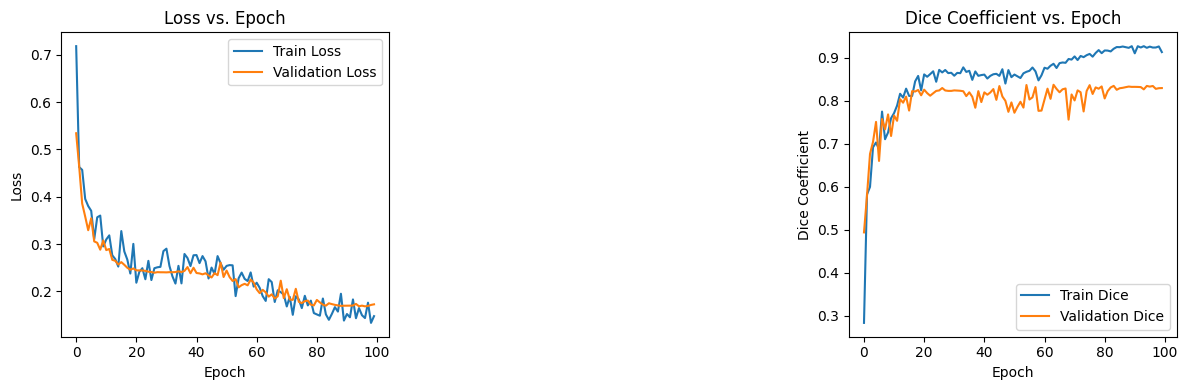

In [21]:
# Plot metrics only if training completed
if len(train_losses) > 0:
    try:        
        # Plot losses
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss vs. Epoch')
        
        # Plot Dice scores
        plt.subplot(1, 3, 3)
        plt.plot(train_dice_scores, label='Train Dice')
        plt.plot(val_dice_scores, label='Validation Dice')
        plt.xlabel('Epoch')
        plt.ylabel('Dice Coefficient')
        plt.legend()
        plt.title('Dice Coefficient vs. Epoch')
        
        plt.tight_layout()
        plt.savefig('training_metrics.png')
        plt.show()
    except Exception as e:
        print(f"Error creating plots: {e}")

In [22]:
# Modeli yükle
model_path = "/kaggle/working/best_brats_model_dice.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modeli oluştur ve ağırlıkları yükle
model = torch.load(model_path, map_location=device)
model = model.to(device)
model.eval()  # Modeli inference moduna al

ImprovedUNet3D(
  (enc1): Sequential(
    (0): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, trac

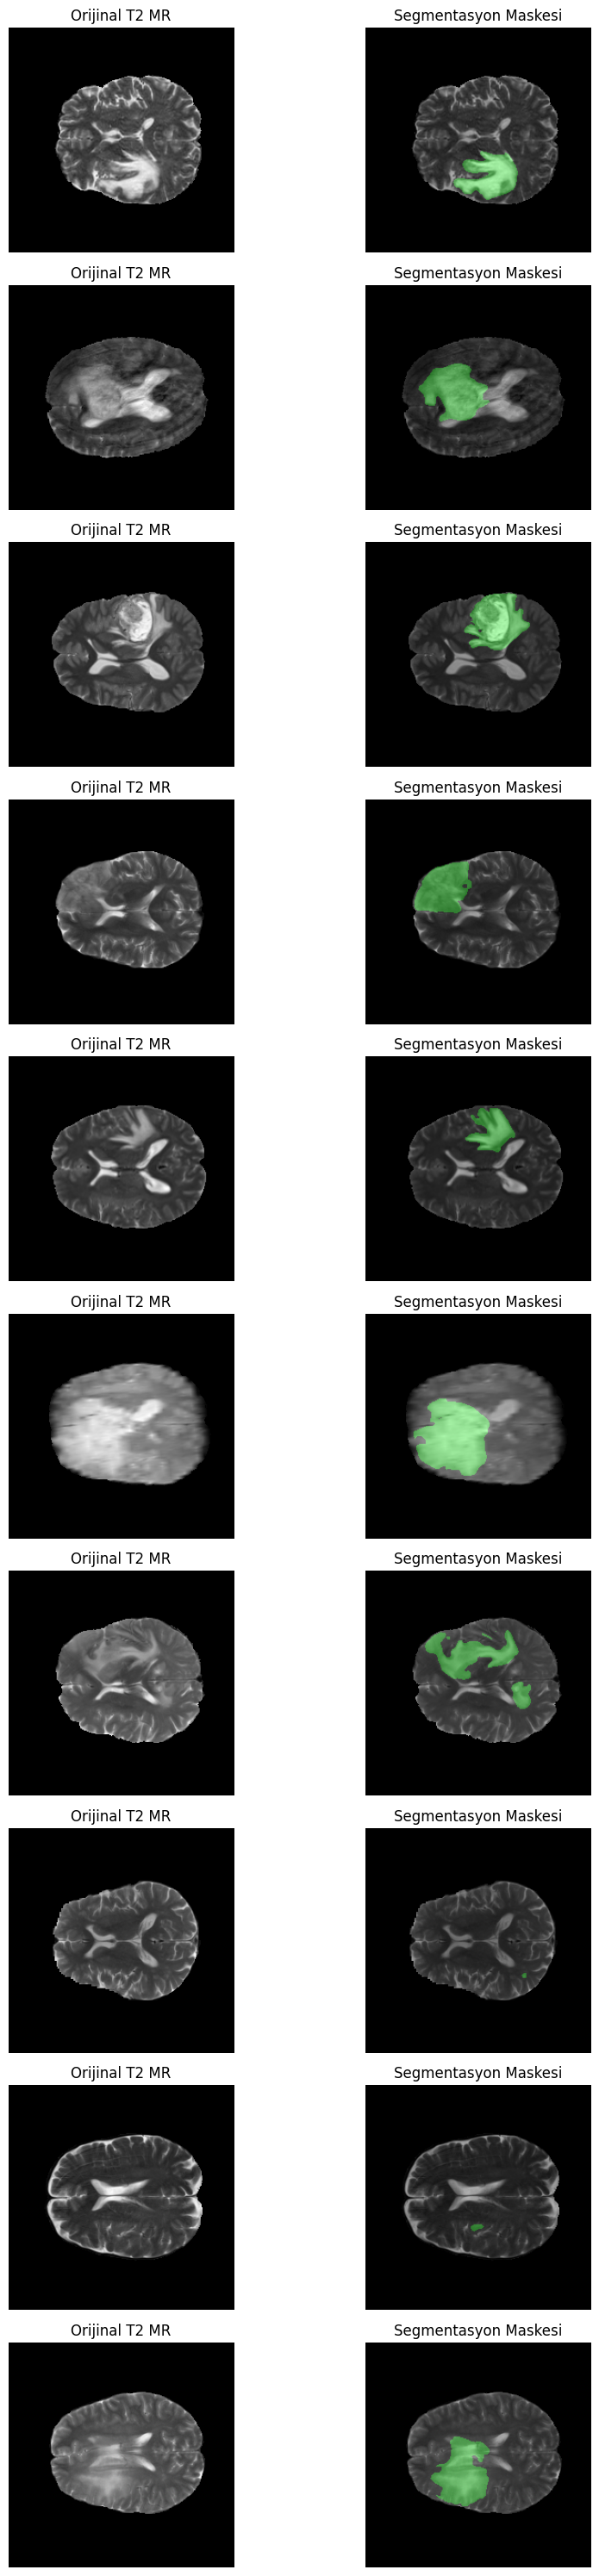

In [23]:
# Take random 10 images
test_iter = iter(test_loader)
num_images = 10
fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))

for i in range(num_images):
    test_image = next(test_iter).to(device)  # (1, 4, H, W, D)

    # Prediction with model
    with torch.no_grad():
        output = model(test_image)  # (1, 2, H, W, D)
        prediction = torch.argmax(output, dim=1).cpu().numpy()  # (1, H, W, D)

    # Transform to numpy
    test_image_np = test_image.cpu().numpy()

    # Select middle slice (e.g. D/2)
    slice_idx = test_image_np.shape[4] // 2  # Depth axis D
    t2_slice = test_image_np[0, 3, :, :, slice_idx]  # T2 modality
    pred_mask = prediction[0, :, :, slice_idx]  # Segmentation mask

    # Normalize and convert to 8-bit (For Image)
    t2_slice = cv2.normalize(t2_slice, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Make it colorful
    t2_colored = cv2.cvtColor(t2_slice, cv2.COLOR_GRAY2BGR)

    # Color the segmentation mask
    mask_colored = np.zeros_like(t2_colored)
    mask_colored[:, :, 1] = (pred_mask * 255).astype(np.uint8)  # Green mask

    # Overlay segmentation transparently onto image
    blended = cv2.addWeighted(t2_colored, 0.7, mask_colored, 0.3, 0)

    # Draw images
    axes[i, 0].imshow(t2_colored)
    axes[i, 0].set_title("Orijinal T2 MR")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(blended)
    axes[i, 1].set_title("Segmentasyon Maskesi")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

## ***Conclusion***

In this study, a deep learning pipeline was created using the 3D U-Net model for brain tumor segmentation. The study includes the following steps:

### ***1. Data Preparation***
MRI images containing FLAIR, T1, T1CE and T2 modalities from the BraTS (Brain Tumor Segmentation) dataset were used.
The BraTSDataset class was created and the PyTorch dataset and data loaders (DataLoader) were configured.
For memory optimization, only the 60-100th slice range where tumors are most frequently seen was used.
The images were normalized to ensure more efficient learning of the model.

### ***2. Model Training***
The 3D U-Net model was defined and trained with GPU acceleration.
The segmentation performance of the model was optimized using Dice Loss.
The best model was recorded as "best_brats_model.pt" according to the validation Dice Score.

### ***3. Testing and Evaluation***
The trained model was evaluated on the test dataset.
Predictions were made on 10 different test images and segmentation masks were generated.
The predicted segmentation masks were visualized by overlaying the original MRI images with OpenCV.

### ***4. Results and Future Work***
The model made successful predictions on tumor segmentation.
When evaluated on the images, it was seen that the tumor areas were clearly separated.

In the future, data augmentation, larger data sets or transfer learning methods can be used to increase the accuracy of the model.
This study demonstrates the effectiveness of deep learning models for MRI-based brain tumor segmentation. The model can be used as a system that provides automatic tumor detection and segmentation that can assist doctors 🚀